In [1]:
import h5py

In [2]:
with h5py.File('data.h5', 'r') as hf:
    X = hf['EEG_values'][:]             #Samples tensor
    y = hf['target_values'][:]          #Targets matrix

In [3]:
X.shape

(2444, 640, 14)

In [4]:
channels_order = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [5]:
class PCA_MTS():
    Index_Samples             = 0
    Index_length_time_sereis  = 1
    Index_features            = 2
    X_normalized = 0
    
    def __init__(self,X):
        
        print("Pls make sure that Input tensor X as shape of M: Samples , ni: length of time sereis , m: Numper of features ")        
        self.X = X
        
        def global_imports(modulename,shortname = None, asfunction = False):
            if shortname is None: 
                shortname = modulename
            if asfunction is False:
                globals()[shortname] = __import__(modulename)
            else:        
                globals()[shortname] = eval(modulename + "." + shortname) 
                
        global_imports("numpy","np")
        global_imports("tensorflow","tf")
        global_imports("tensorflow_probability","tfp")
        global_imports("seaborn","sns")
        global_imports("matplotlib","plt")

        
        #mean of each sample per m features cross ni length
        mean_vector_i = tf.divide(tf.reduce_sum(X, self.Index_length_time_sereis), X.shape[self.Index_length_time_sereis])
        #This result in tensor of shape (M , m)

        #Now broad-castting the tensor intp (M, ni ,m)
        mean_vector_i = np.tile(mean_vector_i, (1,X.shape[self.Index_length_time_sereis])).reshape(X.shape[self.Index_Samples],
                                                                                      X.shape[self.Index_length_time_sereis],
                                                                                      X.shape[self.Index_features])

        PCA_MTS.X_normalized  = tf.subtract(X,mean_vector_i).numpy() #Getting the normalized tensor

        

    def stats_COV(self):
        '''Calculating covariance matrix'''
        
        State_x = PCA_MTS.X_normalized

        DeNormalized_Segma = tfp.stats.covariance(State_x, sample_axis=1, event_axis=2, keepdims=False, name=None)
    
        Segma_COV          = tf.divide(tf.reduce_sum(DeNormalized_Segma, PCA_MTS.Index_Samples), X.shape[PCA_MTS.Index_Samples])
    
        return Segma_COV.numpy() 
    
    def normalized_COV(self):
        '''Calculating correlationg matrix out from covariance matrix'''
        
        store = PCA_MTS.X_normalized
        
        std_x = PCA_MTS.X_normalized
 
    
        std     = tf.math.reduce_std(
            std_x, axis=1, keepdims=False, name=None)
    
        std     = np.tile(std, (1,X.shape[PCA_MTS.Index_length_time_sereis])).reshape(X.shape[PCA_MTS.Index_Samples],
                                                                                      X.shape[PCA_MTS.Index_length_time_sereis],
                                                                                      X.shape[PCA_MTS.Index_features])
        std_x   =  tf.divide(std_x,std)
    
        
        PCA_MTS.X_normalized = std_x
        
        correlation = self.stats_COV()
    
        
        PCA_MTS.X_normalized = store
    
        return correlation
    
    def correlation(self, Columns , figs = (10,10) ,titles = 20):
        
        correlation = self.normalized_COV()
        
        fig, ax = plt.pyplot.subplots(figsize= figs)
        sns.heatmap(tf.math.abs(correlation),
                     cbar=True,
                     annot=True,
                     square=True,
                     fmt='.2f',
                     annot_kws={'size': 12},
                     cmap='coolwarm',                 
                     yticklabels = Columns,
                     xticklabels = Columns,
                     ax = ax)
        plt.pyplot.title('Covariance matrix showing abs correlation coefficients', size = titles)
        plt.pyplot.tight_layout()
        plt.pyplot.show()
        
    
    def eigens(self):
        '''PCA involves projecting the data onto the eigenvectors of the covariance matrix.
        If you don't standardize your data first, these eigenvectors will be all different lengths.
        Then the eigenspace of the covariance matrix will be stretched, leading to similarly "stretched" projections.
        However, there are situations in which you do want to preserve the original variances.
        So I'll save both eigens'''
        
        Corr_eig_vals, Corr_eig_vecs = np.linalg.eig(self.normalized_COV())
        COV_eig_vals, COV_eig_vecs   = np.linalg.eig(self.stats_COV())
        
        return (Corr_eig_vals, Corr_eig_vecs, COV_eig_vals, COV_eig_vecs)
    
    def correlation_explained_var(self,start = 6 , end = 12 , figs = (10,10)):
        '''Percentage of Explained Variance using correlation matrix'''
        eig_vals , eig_vecs , Junk , Junk = self.eigens()
        
        start = start-1
        Explained_Var = [(i / sum(eig_vals))*100 for i in sorted(eig_vals, reverse=True)]
        cum_Explained_Var = np.cumsum(Explained_Var)
        with plt.pyplot.style.context('seaborn-whitegrid'):
            plt.pyplot.figure(figsize=figs)

            plt.pyplot.bar(range(X.shape[self.Index_features]), Explained_Var, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.pyplot.step(range(X.shape[self.Index_features]), cum_Explained_Var, where='mid',
                     label='cumulative explained variance')
            plt.pyplot.ylabel('Explained variance ratio')
            plt.pyplot.xlabel('Principal components')
            plt.pyplot.legend(loc='best')
            plt.pyplot.tight_layout()
            for i in range(start,end,1):
                print('Percentage of Explained Variance using correlation matrix if we used %s Components is:'%(i+1) +str(cum_Explained_Var[i])+'%'+'\n')

    def covariance_explained_var(self,start = 6 , end = 12 , figs = (10,10)):
        '''Percentage of Explained Variance using covariance matrix'''
        Junk , Junk , eig_vals , eig_vecs = self.eigens()
        
        start = start-1
        Explained_Var = [(i / sum(eig_vals))*100 for i in sorted(eig_vals, reverse=True)]
        cum_Explained_Var = np.cumsum(Explained_Var)
        with plt.pyplot.style.context('seaborn-whitegrid'):
            plt.pyplot.figure(figsize=figs)

            plt.pyplot.bar(range(X.shape[self.Index_features]), Explained_Var, alpha=0.5, align='center',
                    label='individual explained variance')
            plt.pyplot.step(range(X.shape[self.Index_features]), cum_Explained_Var, where='mid',
                     label='cumulative explained variance')
            plt.pyplot.ylabel('Explained variance ratio')
            plt.pyplot.xlabel('Principal components')
            plt.pyplot.legend(loc='best')
            plt.pyplot.tight_layout()
            for i in range(start,end,1):
                print('Percentage of Explained Variance using covariance matrix if we used %s Components is:'%(i+1) +str(cum_Explained_Var[i])+'%'+'\n')
        

In [6]:
Obj = PCA_MTS(X)

Pls make sure that Input tensor X as shape of M: Samples , ni: length of time sereis , m: Numper of features 


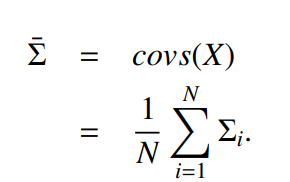

In [7]:
Obj.stats_COV()

array([[ 1630.3962 ,  1410.2891 ,   976.7504 ,  1006.1937 ,   941.13043,
          710.7671 ,   786.8628 ,  1215.7537 ,  1735.0887 ,  1714.4946 ,
         1300.9956 ,  1125.009  ,  1563.0231 ,  1436.6045 ],
       [ 1410.2891 ,  6275.8447 ,  1273.9932 ,  1807.9542 ,  1367.9004 ,
         1000.181  ,   886.51483,  2164.0051 ,  2813.5525 ,  2972.1143 ,
         2107.6155 ,  2054.1877 ,  3468.201  ,  2243.2334 ],
       [  976.7504 ,  1273.9932 ,  1528.8323 ,   902.39465,   873.0339 ,
          631.7303 ,   736.5418 ,  1144.1544 ,  1497.7963 ,  1597.0033 ,
         1163.1116 ,  1089.404  ,  1400.299  ,  1225.89   ],
       [ 1006.1937 ,  1807.9542 ,   902.39465,  1920.6444 ,   891.6694 ,
          659.48096,   781.25885,  1322.8171 ,  1824.9202 ,  1730.1477 ,
         1455.1156 ,  1208.0358 ,  1550.7286 ,  1423.1133 ],
       [  941.13043,  1367.9004 ,   873.0339 ,   891.6694 ,  1984.3232 ,
          767.1174 ,   803.76624,  1072.7114 ,  1461.1885 ,  1556.7335 ,
         1094.4598 ,   907

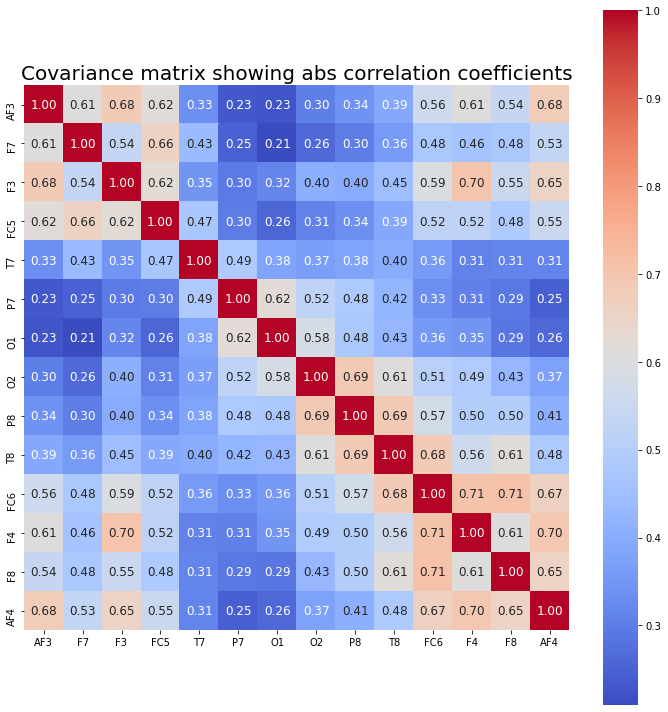

In [8]:
Obj.correlation(channels_order)

Percentage of Explained Variance using correlation matrix if we used 6 Components is:82.88066718374762%

Percentage of Explained Variance using correlation matrix if we used 7 Components is:85.57256177205932%

Percentage of Explained Variance using correlation matrix if we used 8 Components is:88.15610256548133%

Percentage of Explained Variance using correlation matrix if we used 9 Components is:90.41298222812458%

Percentage of Explained Variance using correlation matrix if we used 10 Components is:92.63298428373979%

Percentage of Explained Variance using correlation matrix if we used 11 Components is:94.7052042843585%

Percentage of Explained Variance using correlation matrix if we used 12 Components is:96.61989601895091%



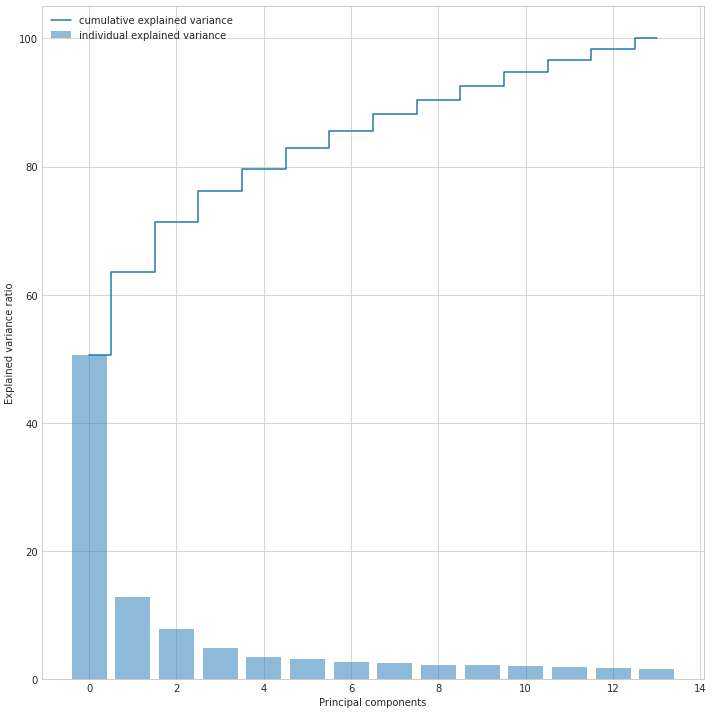

In [9]:
Obj.correlation_explained_var()

Percentage of Explained Variance using covariance matrix if we used 6 Components is:88.81468263292288%

Percentage of Explained Variance using covariance matrix if we used 7 Components is:91.32009269438635%

Percentage of Explained Variance using covariance matrix if we used 8 Components is:93.0038324180396%

Percentage of Explained Variance using covariance matrix if we used 9 Components is:94.5385933097702%

Percentage of Explained Variance using covariance matrix if we used 10 Components is:95.92116804496852%

Percentage of Explained Variance using covariance matrix if we used 11 Components is:97.23296141060884%

Percentage of Explained Variance using covariance matrix if we used 12 Components is:98.35113049624425%



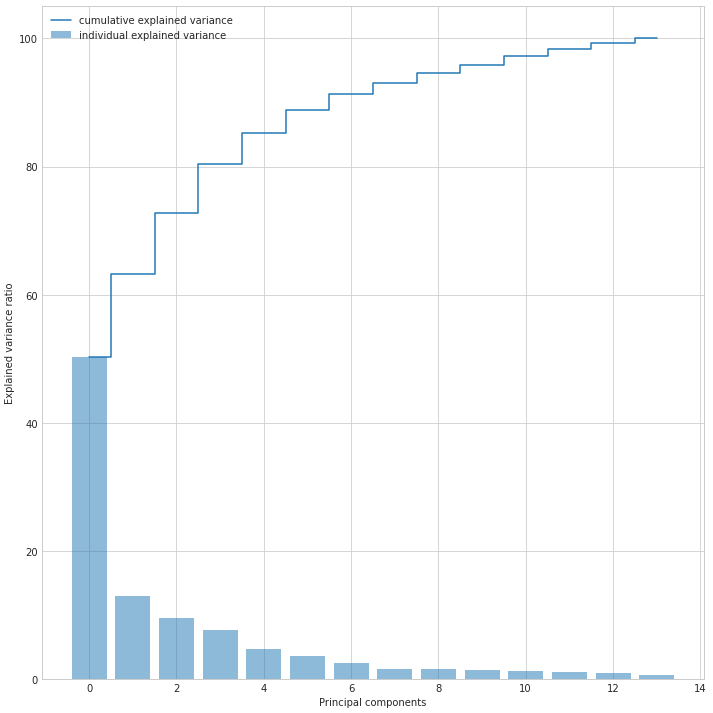

In [10]:
Obj.covariance_explained_var()